In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

### Define constants to be used later

In [4]:
last_day_of_data_dt = dt.date(2017,8,23)

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [8]:
# We can view all of the classes that automap found
inspector = inspect(engine)
table_names = inspector.get_table_names()
for table in table_names:
    print(f"{table}")
    column_names = inspector.get_columns(table)
    for column in column_names:
        PK = "  -PK-" if column['primary_key'] == 1 else ""
        print(f"\t{column['name']} {column['type']} {PK}")
    print("-"*50)

measurement
	id INTEGER   -PK-
	station TEXT 
	date TEXT 
	prcp FLOAT 
	tobs FLOAT 
--------------------------------------------------
station
	id INTEGER   -PK-
	station TEXT 
	name TEXT 
	latitude FLOAT 
	longitude FLOAT 
	elevation FLOAT 
--------------------------------------------------


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station =  Base.classes.station 

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
plt.style.available
import matplotlib.ticker as ticker
# Played with different styles, but in the end kept the fivethirtyeight as it was defined above

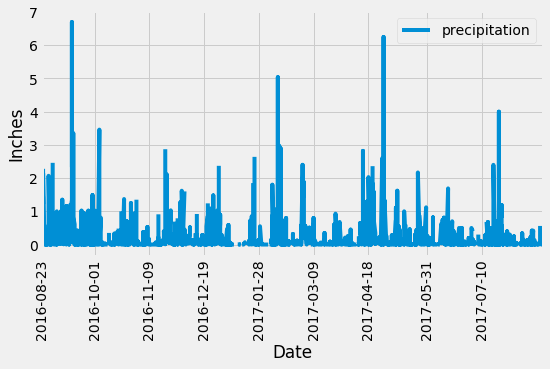

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
twelve_months_delta = relativedelta(months=12)
one_year_ago_date = last_day_of_data_dt - twelve_months_delta

# Perform a query to retrieve the data and precipitation scores
last_12_months = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_12_months_df = pd.DataFrame(last_12_months, columns=['date', 'prcp'])
last_12_months_df.set_index("date", inplace=True)
last_12_months_df.index = pd.to_datetime(last_12_months_df.index)

# Sort the dataframe by date
last_12_months_df.sort_values("date", inplace=True)

xticks = []
min_date = last_12_months_df.index.min()
max_date = last_12_months_df.index.max()
min_tick_date = min_date
date_tick = min_tick_date

#HOW THE *#LDK WERE THESE XTICKS NATURALLY DETERMINED!!!!!!!
#I PROBABLY SHOULD HAVE JUST HARD CODED!!!!!!
days = 39
iterations = 0
max_comparison_date = max_date - dt.timedelta(days=days)
step = 1
while date_tick < max_comparison_date:
    xticks.append(date_tick)
    date_tick = date_tick + dt.timedelta(days=days)
    iterations += step
    if iterations == 2:
        days+=1
    if iterations == 6:
        days+=3
    if iterations == 7:
        days-=3
        

# Use Pandas Plotting with Matplotlib to plot the data
ax = last_12_months_df.plot(xlim=min_tick_date, xticks=xticks, rot=90,figsize=(8,5))
patches, labels = ax.get_legend_handles_labels()
labels[0] = "precipitation"
ax.set_xlabel("Date")
ax.set_ylabel("Inches")
ax.legend(patches, labels, loc='upper right')
ax.set_xlim(min_date, max_date)

#Cener the horizontal ticks
for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12_months_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel=[Station.station,
    func.count(Measurement.date)]
active_stations_query = session.query(*sel).filter(Measurement.station == Station.station).group_by(Station.station) \
        .order_by(func.count(Measurement.date).desc())
active_stations_query.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = active_stations_query.limit(1)[0][0]
most_active_station
sel=[func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)]

statistics = session.query(*sel).filter(Measurement.station == Station.station).filter(Station.station == most_active_station).all()
print(f"Statistics for most active station: {most_active_station}")
print(f"\tlowest temperature recorded : {statistics[0][0]}")
print(f"\thighest temperature recorded: {statistics[0][1]}")
print(f"\taverage temperature recorded: {round(statistics[0][2], 1)}")


Statistics for most active station: USC00519281
	lowest temperature recorded : 54.0
	highest temperature recorded: 85.0
	average temperature recorded: 71.7


USC00519397
361


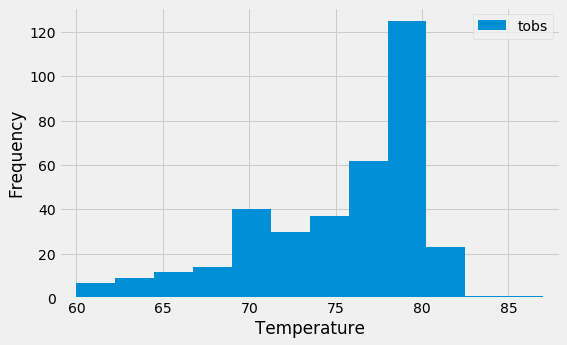

In [34]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel=[Station.station,
    func.count(Measurement.tobs)]


active_stations_query = session.query(*sel).filter(Measurement.station == Station.station) \
        .filter(Measurement.date >= one_year_ago_date).group_by(Station.station) \
        .filter(Measurement.tobs != None) \
        .order_by(func.count(Measurement.tobs).desc())
selected_station = active_stations_query.limit(1)[0][0]

print(selected_station)

last_12_months_temp = session.query(Measurement.date, Measurement.tobs) \
        .filter(Measurement.date >= one_year_ago_date) \
        .filter(Measurement.station == selected_station).all()

dates = []
temperatures = []
for date, temperature in last_12_months_temp:
    dates.append(date)
    temperatures.append(temperature)

min_temp = min(temperatures)
max_temp = max(temperatures)

print(len(temperatures))

fig = plt.figure(figsize=(8,5))
#ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
ax = plt.hist(temperatures, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.xlim(min_temp -1, max_temp + 1)

plt.legend(("tobs",), loc="best")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
